# Blind Image Deconvolution (BID) Demonstration

This notebook gives a demonstration of one type of Blind Image Deconvolution using the modified Davey Algorithm.

We begin with some housekeeping (Python imports)

In [1]:
import imageio                                                # Image file I/O
import numpy as np                                            # Matrix support, FFT etc
import math
from scipy import signal                                      # Signal processing library
from IPython.display import Math                              # LaTex support
import matplotlib.pyplot as plot                              # Plots

from modifiedDaveyDeblur import bid_davey, InitialEstimate    # Blind image deconvolution

Next, import our image of choice...

Source image dimensions: (255, 254, 3)


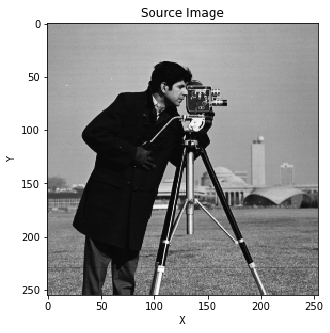

In [2]:
image_name = 'src_images/cameraman.bmp'


# Load and show source image
src_img = imageio.imread(image_name)
print "Source image dimensions:", src_img.shape

plot.figure(figsize=(5,5))
plot.title('Source Image')
plot.xlabel('X')
plot.ylabel('Y')
plot.imshow(src_img)

Next, we add some 'atmospheric blurring'. This is achieved by running the source image through a circular (pillbox) filter.

If:
* f(x,y) is our source image before blurring
* h(x,y) is the effective transfer function modelling the blurring mechanism (Point Spread Function)
* g(x,y) is our blurred image

then we have:

In [3]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y)')

<IPython.core.display.Math object>

Realisitically some noise is added (electronic noise, thermal noise at the CCD camera, quantisation noise). We model this by using an additive unknown noise term n(x,y), with the properites of being a zero-mean Gaussian random variable.

so we now have:

In [4]:
Math(r'g(x,y) =  f(x,y) \otimes h(x,y) + n(x,y)')

<IPython.core.display.Math object>

We can define the signal to noise ratio (SNR) as:


In [5]:
Math(r'SNR = 20\log_{20}  \Bigg(   \frac {A_{signal}} {A_{noise}} \Bigg)')

<IPython.core.display.Math object>

In [6]:
#Math(r'SNR = \log_{10}  \Bigg(   \frac {\int_{}^{} \lvert f(x,y) \otimes h(x,y) \rvert ^2 dx dy} {\int_{}^{} |n(x,y)|^2 dx dy }  \Bigg)')

Blur the image by 2D-convolution of each RGB colour channel with the PSF...

Blurred image dimensions: (275, 274, 3)
[[[ 8.65982450e+00 -9.47515924e+00  1.12630783e+01]
  [ 6.78939599e+00 -1.48030527e+01 -1.55706022e+01]
  [-2.06011256e+00  6.99076232e+00 -3.94683300e+00]
  ...
  [ 2.57554844e+00 -1.06385251e+01  1.20531918e+01]
  [ 8.83894783e+00 -4.26130449e+00 -6.34915962e+00]
  [-5.03836297e-01 -1.97629643e+01 -1.19275555e+01]]

 [[-8.69471228e+00  3.40182067e+00  1.61978681e+01]
  [-2.04656168e+00  7.62089089e-01 -3.27750303e+00]
  [ 9.13489489e+00  2.06859610e+00 -9.01381198e+00]
  ...
  [ 2.77143985e+01  6.84717033e+00  5.21785638e-02]
  [ 9.50282517e+00 -7.99171369e+00  1.70432632e+01]
  [-6.98848348e+00 -8.57475765e+00  1.65288951e+01]]

 [[ 3.46798343e+00 -4.82716835e+00 -1.46990632e+01]
  [ 1.43697086e+01 -7.70117331e+00  6.29060344e+00]
  [ 2.43951542e+00  4.20208484e+00 -4.85491770e+00]
  ...
  [-1.88442712e+01 -1.17163140e+01  9.68477418e+00]
  [ 7.44897597e+00  3.79323063e+00  1.66808256e+00]
  [ 6.64724185e+00  4.09763174e+00 -1.27465881e+00]]



Text(0,0.5,u'Y')

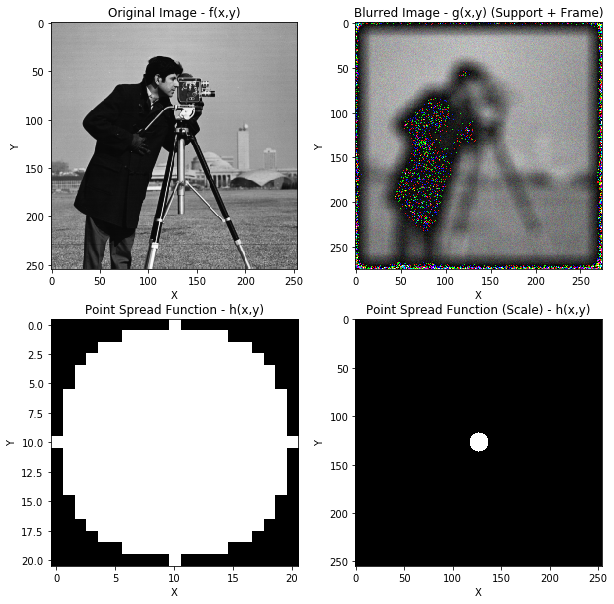

In [7]:
# Create circular filter PSF
r = 10
y,x = np.ogrid[-r: r+1, -r: r+1]
psf = x**2+y**2 <= r**2
psf = psf.astype(float) / np.sum(psf)


blur_img = np.zeros((src_img.shape[0] + 2*r, src_img.shape[1] + 2*r, src_img.shape[2]))
print "Blurred image dimensions:", blur_img.shape

for ch in range(src_img.shape[2]):    
    blur_img[:,:,ch] = signal.convolve2d(src_img[:,:,ch], psf, mode ='full', boundary = 'fill', fillvalue = 0)


# Add noise to observed image
snr_db, mu, sigma = 6., 0, 0.1

thismax = np.max(blur_img).astype(float)
magnitude = np.max(blur_img).astype(float) / math.pow(10, snr_db / 20.)
noise = magnitude*np.random.normal(mu, sigma, blur_img.shape)
print noise
blur_img = np.add(blur_img, noise)


print "max signal: " + str(thismax)
print "magnitude: " + str(magnitude)


imageio.imsave( '_blurred.'.join(image_name.rsplit('.', 1)), (np.divide(blur_img, np.max(blur_img))*255).astype(np.uint8))
   
    
blur_img = np.round(blur_img, 0).astype(np.uint8)

# Plot before and after blurring
plot.figure(figsize=(10,10))
plot.subplot(2, 2, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(2, 2, 2)
plot.imshow(blur_img)
plot.title('Blurred Image - g(x,y) (Support + Frame)')
plot.xlabel('X')
plot.ylabel('Y')


# Show PSF
psfplot = np.zeros((src_img.shape[0], src_img.shape[1]))
nb = psfplot.shape[0]
na = psf.shape[0]
lower = (nb) // 2 - (na // 2)
upper = (nb) // 2 + math.ceil(float(na) / 2)
psfplot[lower:int(upper), lower:int(upper)] = psf

plot.subplot(2, 2, 3)
plot.imshow(psf, cmap='gray')
plot.title('Point Spread Function - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


plot.subplot(2, 2, 4)
plot.imshow(psfplot, cmap='gray')
plot.title('Point Spread Function (Scale) - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')



Chose blurred image
Performing optimal deblur. Progress: [ . . . . . . . . . . . . . . . . . . . . ] (complete)
Results:
--------
Minimum MSE of 1463 occurs at iteration# 0.


Text(0,0.5,u'MSE')

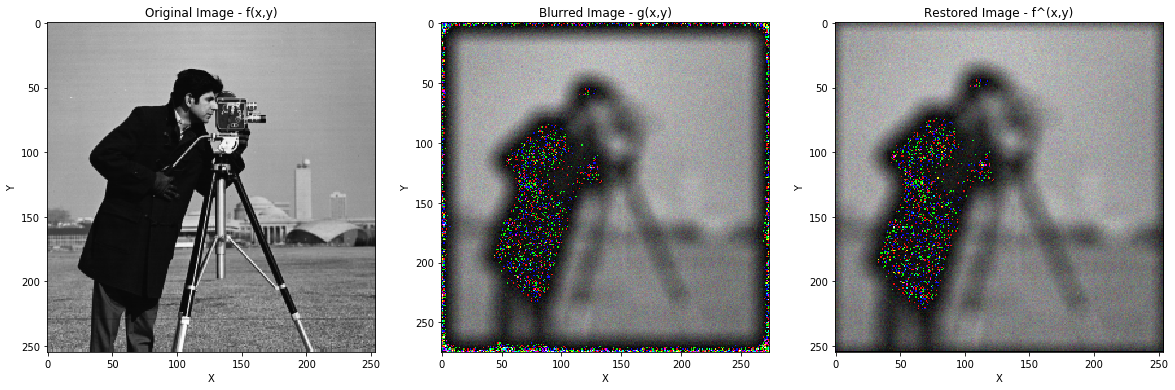

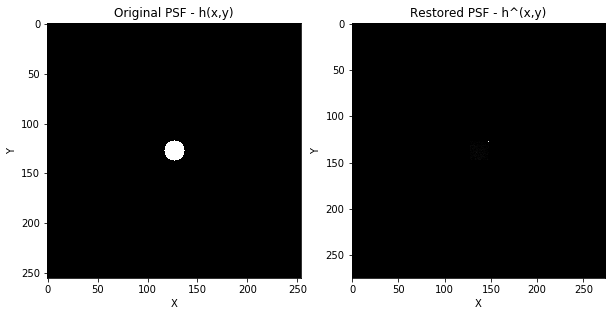

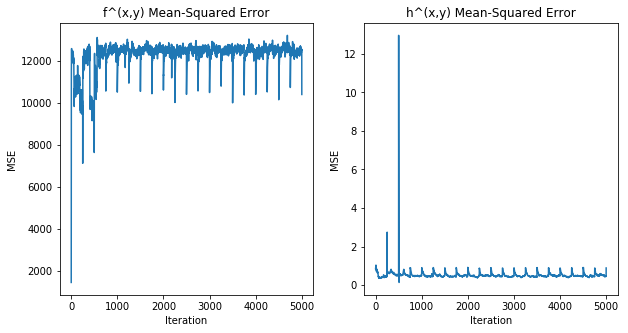

In [8]:
# BID iterations
iterations = 5000
save_snapshots = True

(restored_img, restored_psf, image_mse, psf_mse, mse_min, mse_min_iterations) = bid_davey(src_img, psfplot, blur_img, psf.shape, iterations, InitialEstimate.BLURRED_IMAGE, save_snapshots)

imageio.imsave( '_restored.'.join(image_name.rsplit('.', 1))  , restored_img) # Save the result



print "Results:"
print "--------"
print "Minimum MSE of %d occurs at iteration# %d." % (math.ceil(mse_min), mse_min_iterations)

# Plot recovered image
plot.figure(figsize=(20,20))
plot.subplot(1, 3, 1)
plot.imshow(src_img)
plot.title('Original Image - f(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 2)
plot.imshow(blur_img)
plot.title('Blurred Image - g(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 3, 3)
plot.imshow(restored_img)
plot.title('Restored Image - f^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot recovered PSF
plot.figure(figsize=(10,10))
plot.subplot(1, 2, 1)
plot.imshow(psfplot, cmap='gray')
plot.title('Original PSF - h(x,y)')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 2, 2)
plot.imshow(restored_psf, cmap='gray')
plot.title('Restored PSF - h^(x,y)')
plot.xlabel('X')
plot.ylabel('Y')


# Plot MSE
plot.figure(figsize=(10,5))
plot.subplot(1, 2, 1)
plot.plot(image_mse[:,1])
plot.title('f^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')

plot.subplot(1, 2, 2)
plot.plot(psf_mse[:,1])
plot.title('h^(x,y) Mean-Squared Error')
plot.xlabel('Iteration')
plot.ylabel('MSE')



Text(0,0.5,u'Y')

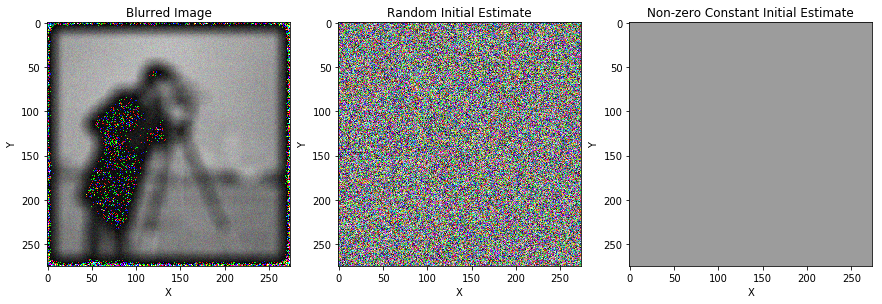

In [9]:
# Show Initial Condition Options
imgHeight = blur_img.shape[0]
imgWidth = blur_img.shape[1]
imgChannels = blur_img.shape[2]

initial_estimate_A = blur_img
initial_estimate_B = np.round(255*np.random.rand(imgHeight, imgWidth, imgChannels))
initial_estimate_C = np.multiply(np.ones((imgHeight, imgWidth, imgChannels)), 100)


plot.figure(figsize=(20,20))
plot.subplot(1, 4, 1)
plot.imshow(initial_estimate_A)
plot.title('Blurred Image')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 4, 2)
plot.imshow(initial_estimate_B)
plot.title('Random Initial Estimate')
plot.xlabel('X')
plot.ylabel('Y')

plot.subplot(1, 4, 3)
plot.imshow(initial_estimate_C)
plot.title('Non-zero Constant Initial Estimate')
plot.xlabel('X')
plot.ylabel('Y')    